# About

- `Title:` "Lower and Upper Bounds on the VC-Dimension of Tensor Network Models"
- `Main Author:` Behnoush Khavari
- `Source:` [ArXiv](https://arxiv.org/abs/2106.11827)
- `Publish Date:` 22-06-2021
- `Reviewed Date:` 22-11-2021

## Citation

```latex
@article{khavari2021lower,
  title={Lower and Upper Bounds on the VC-Dimension of Tensor Network Models},
  author={Khavari, Behnoush and Rabusseau, Guillaume},
  journal={arXiv preprint arXiv:2106.11827},
  year={2021}
}
```

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import matplotlib.pyplot as plt

In [4]:
from functools import reduce

# Random Data Generation

In [5]:
def random_mps(
    size: int,
    local_dim: int,
    bond_dim: int,
    dtype=jnp.float64,
    seed=0):
    """
    Generate a random MPS where each core tensor
    is draws i.i.d. from a uniform distribution 
    between -1 and 1.

    Input:
    ------
    size:       The size of the MPS
    local_dim:  The local dimension size
    bond_dim:   The bond dimension size
    dtype:      The type of data to return.
    seed:       A random seed.
    """
    # initialize MPS data collection
    mps = []
    
    # initialize PRNGKey
    key = jax.random.PRNGKey(seed)
    
    for i in range(size):
        _, key = jax.random.split(key)
        if i == 0:  # left most tensor
            tensor = jax.random.uniform(
                key, shape=(1, local_dim, bond_dim), minval=-1, maxval=1, dtype=dtype)
        elif i == size-1:  # right most tensor
            tensor = jax.random.uniform(
                key, shape=(bond_dim, local_dim, 1), minval=-1, maxval=1, dtype=dtype)
        else:  # middle tensors
            tensor = jax.random.uniform(
                key, shape=(bond_dim, local_dim, bond_dim), minval=-1, maxval=1, dtype=dtype)
        mps.append(tensor)

    return mps

In [6]:
def random_sample(
    size: int,
    local_dim: int,
    n_factors: int,
    dtype=jnp.float64,
    seed=0):
    """
    Generate random data samples where components
    are drawn i.i.d. from a normal distribution.

    Input:
    ------
    size:           The sample size.
    local_dim:      The dimension each sample.
    n_factors:      The number of factors (equal the size of the MPS).
    dtype:          The type of data to return.
    seed:           A random seed.
    """
    # initialize the collection
    samples = []
    
    # initialize PRNGKey
    key = jax.random.PRNGKey(seed)
    
    for i in range(size):
        x = [] 
        for j in range(n_factors):
            _, key = jax.random.split(key)
            xi = jax.random.normal(
                key, 
                shape=(local_dim,), 
                dtype=dtype)
            x.append(xi)
        samples.append(x)

    return jnp.asarray(samples)

In [7]:
def contract(params, inputs):
    """Contract MPS with data"""
    def _contract_single_core(params, input):
        """
        Contract an individual core tensor with data component.
        --W--
          |   = --(Wx)--
          x
        """
        core_tensors = [jnp.einsum('pqr,q->pr', p, i)
                        for p, i in zip(params, input)]
        # full reduction (contraction)
        return reduce(lambda Wi, Wj: Wi @ Wj, core_tensors)
    
    output = [_contract_single_core(params, inp) 
              for inp in inputs]
    return jnp.asarray(output)

def sigmoid(x):
    return 1. / (1. + jnp.exp(-x))

def predict_proba(params, inputs):
    outputs = contract(params, inputs)
    return sigmoid(outputs)

def get_labels(proba):
    output = [1 if y >= 0.5 else 0 for y in proba]
    return jnp.asarray(output)

# Training

In [8]:
import time
import itertools

import numpy.random as npr

from jax import jit, grad
from jax.example_libraries import optimizers

## Constants

In [9]:
# PRNG seed
SEED = 271

# model size
MPS_SIZE = 4
LOCAL_DIM = 4
BOND_DIM = 8
RANK = [2, 4, 6, 8, 10, 12, 14] # as used in the paper

# data sample
TEST_SIZE = 4000
TRAIN_SIZE = [100, 200, 500, 1000, 2000, 3000, 4000]

# training params
LEARNING_RATE = 1e-2
NUM_EPOCHS = 7

## Cross-entropy loss

In [10]:
def binary_cross_entropy(targets, outputs, from_logits=False):
    if not from_logits:
        outputs = jnp.clip(outputs, 1e-7, 1 - 1e-7)
        outputs = jnp.log2(outputs / (1 - outputs))
    bce = targets * -jnp.log2(sigmoid(outputs)) + \
          (1 - targets) * -jnp.log2(1 - sigmoid(outputs))
    return bce

def loss(params, batch):
    inputs, targets = batch
    outputs = predict_proba(params, inputs)
    bce = binary_cross_entropy(targets, outputs, from_logits=False)
    return jnp.mean(bce)

def risk(params, batch):
    inputs, targets = batch
    outputs = predict_proba(params, inputs)
    return jnp.mean(get_labels(outputs) != targets)

## Optimization

In [11]:
@jit
def update(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)

## Execution

In [12]:
# target MPS model
true_params = random_mps(size=MPS_SIZE, local_dim=LOCAL_DIM, bond_dim=BOND_DIM, seed=SEED)      
# generate test samples
test_data = random_sample(size=TEST_SIZE, local_dim=LOCAL_DIM, n_factors=MPS_SIZE, seed=SEED)
# generate labels by contracting MPS with data
test_labels = get_labels(predict_proba(true_params, test_data))

# storing results
results = {}

for rank in RANK:
    
    print(f"Rank {rank}")
    print('*'*40)
    results[rank] = {}
    
    # initialize MPS parameters
    init_params = random_mps(size=MPS_SIZE, local_dim=LOCAL_DIM, bond_dim=rank, seed=SEED+1)
    
    for train_size in TRAIN_SIZE:
  
        gen_gap = []
    
        # generate samples
        train_data = random_sample(size=train_size, local_dim=LOCAL_DIM, n_factors=MPS_SIZE, seed=SEED+1)
        # generate labels by contracting MPS with data
        train_labels = get_labels(predict_proba(true_params, train_data))

        batch_size = min(train_size // 10, 30)
        
        num_complete_batches, leftover = divmod(train_size, batch_size)
        num_batches = num_complete_batches + bool(leftover)

        def data_iterator():
            rng = npr.RandomState(SEED)
            while True:
                perm = rng.permutation(train_size)
                for i in range(num_batches):
                    batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                    yield train_data[batch_idx], train_labels[batch_idx]

        batches = data_iterator()
        
        # params for the optimization (initial guess)
        opt_init, opt_update, get_params = optimizers.sgd(step_size=LEARNING_RATE)

        opt_state = opt_init(init_params)
       
        # counter
        itercount = itertools.count()

        tic = time.time()
        print(f"Starting training - sample size '{train_size}'...")
        for epoch in range(NUM_EPOCHS):
            
            for _ in range(num_batches):
                opt_state = update(next(itercount), opt_state, next(batches))
            
            params = get_params(opt_state)
            
            # computing risk
            empir_risk = risk(params, (train_data, train_labels))
            expec_risk = risk(params, (test_data, test_labels))

            print(f'Epoch: {epoch+1} - Empirical risk {empir_risk:0.2f}; ' +\
                  f'Expected risk {expec_risk:0.2f}')
            
            # storing generalization bound
            gap = jnp.abs(expec_risk - empir_risk)
            gap = jnp.clip(gap, 1e-7, 1e+7)
            gen_gap.append(gap)

        print(f"Time for {train_size} in {(time.time() - tic):0.2f} sec")
        print("Generalisation {:0.4f}".format(gen_gap[-1]))
        print('-'*40)
        
        results[rank][train_size] = jnp.asarray(gen_gap)

Rank 2
****************************************
Starting training - sample size '100'...
Epoch: 1 - Empirical risk 0.55; Expected risk 0.53
Epoch: 2 - Empirical risk 0.54; Expected risk 0.53
Epoch: 3 - Empirical risk 0.56; Expected risk 0.53
Epoch: 4 - Empirical risk 0.58; Expected risk 0.53
Epoch: 5 - Empirical risk 0.56; Expected risk 0.53
Epoch: 6 - Empirical risk 0.55; Expected risk 0.54
Epoch: 7 - Empirical risk 0.57; Expected risk 0.53
Time for 100 in 12.11 sec
Generalisation 0.0358
----------------------------------------
Starting training - sample size '200'...
Epoch: 1 - Empirical risk 0.57; Expected risk 0.53
Epoch: 2 - Empirical risk 0.58; Expected risk 0.53
Epoch: 3 - Empirical risk 0.57; Expected risk 0.53
Epoch: 4 - Empirical risk 0.56; Expected risk 0.53
Epoch: 5 - Empirical risk 0.56; Expected risk 0.53
Epoch: 6 - Empirical risk 0.55; Expected risk 0.53
Epoch: 7 - Empirical risk 0.55; Expected risk 0.53
Time for 200 in 13.34 sec
Generalisation 0.0168
-------------------

Epoch: 5 - Empirical risk 0.47; Expected risk 0.47
Epoch: 6 - Empirical risk 0.47; Expected risk 0.47
Epoch: 7 - Empirical risk 0.49; Expected risk 0.47
Time for 500 in 17.55 sec
Generalisation 0.0222
----------------------------------------
Starting training - sample size '1000'...
Epoch: 1 - Empirical risk 0.48; Expected risk 0.45
Epoch: 2 - Empirical risk 0.48; Expected risk 0.46
Epoch: 3 - Empirical risk 0.47; Expected risk 0.46
Epoch: 4 - Empirical risk 0.46; Expected risk 0.45
Epoch: 5 - Empirical risk 0.47; Expected risk 0.45
Epoch: 6 - Empirical risk 0.46; Expected risk 0.45
Epoch: 7 - Empirical risk 0.46; Expected risk 0.45
Time for 1000 in 13.57 sec
Generalisation 0.0108
----------------------------------------
Starting training - sample size '2000'...
Epoch: 1 - Empirical risk 0.48; Expected risk 0.45
Epoch: 2 - Empirical risk 0.47; Expected risk 0.45
Epoch: 3 - Empirical risk 0.48; Expected risk 0.45
Epoch: 4 - Empirical risk 0.47; Expected risk 0.45
Epoch: 5 - Empirical ri

Epoch: 1 - Empirical risk 0.51; Expected risk 0.48
Epoch: 2 - Empirical risk 0.49; Expected risk 0.48
Epoch: 3 - Empirical risk 0.47; Expected risk 0.47
Epoch: 4 - Empirical risk 0.46; Expected risk 0.47
Epoch: 5 - Empirical risk 0.50; Expected risk 0.50
Epoch: 6 - Empirical risk 0.52; Expected risk 0.53
Epoch: 7 - Empirical risk 0.46; Expected risk 0.48
Time for 3000 in 19.70 sec
Generalisation 0.0161
----------------------------------------
Starting training - sample size '4000'...
Epoch: 1 - Empirical risk 0.47; Expected risk 0.47
Epoch: 2 - Empirical risk 0.48; Expected risk 0.48
Epoch: 3 - Empirical risk 0.49; Expected risk 0.50
Epoch: 4 - Empirical risk 0.44; Expected risk 0.46
Epoch: 5 - Empirical risk 0.48; Expected risk 0.50
Epoch: 6 - Empirical risk 0.49; Expected risk 0.49
Epoch: 7 - Empirical risk 0.50; Expected risk 0.51
Time for 4000 in 22.59 sec
Generalisation 0.0040
----------------------------------------
Rank 12
****************************************
Starting traini

# Save results

In [13]:
# import pickle

# time_stamp = time.strftime("%Y-%m-%d", time.localtime())

# with open(f"results-{time_stamp}-{LEARNING_RATE}-{NUM_EPOCHS}-{SEED}.pkl", "wb") as f:
#     pickle.dump(results, f)

# Plot Generalization vs. Sample Size

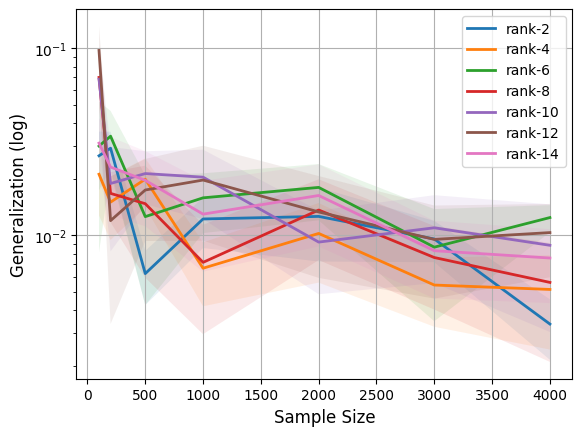

In [14]:
def plot_rank(results):
    for rank, res in results.items():
        mean = jax.tree_map(jnp.mean, res)
        ci = jax.tree_map(lambda x: 1.96 * x / jnp.sqrt(len(res)), 
                          jax.tree_map(jnp.std, res))
        keys, mean = zip(*mean.items())
        _, ci = zip(*ci.items())
        err_l, err_h = zip(*[(m-e, m+e) for m,e in zip(mean, ci)])
        plt.plot(keys, mean, label=f'rank-{rank}', linewidth=2)
        plt.fill_between(keys, err_l, err_h, alpha=0.1)
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Sample Size', fontsize=12)
    plt.ylabel('Generalization (log)', fontsize=12)
    plt.show()

plot_rank(results)

# Plot Generalizations vs. MPS Rank

In [15]:
plot1_data = {}
plot2_data = {}

for rank, dic in results.items():
    if rank in (2, 4):
        plot1_data[rank] = dic
    for sample_size, data in dic.items():
        if sample_size in (2000, 4000):
            plot2_data.setdefault(sample_size, {})[rank] = data

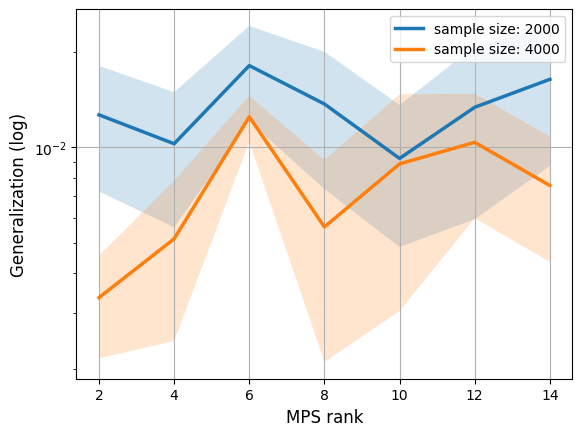

In [16]:
def plot_sample(results):
    for sample, res in results.items():
        mean = jax.tree_map(jnp.mean, res)
        ci = jax.tree_map(lambda x: 1.96 * x / jnp.sqrt(len(res)), 
                          jax.tree_map(jnp.std, res))
        keys, mean = zip(*mean.items())
        _, ci = zip(*ci.items())
        err_l, err_h = zip(*[(m-e, m+e) for m,e in zip(mean, ci)])
        plt.plot(keys, mean, label=f'sample size: {sample}', linewidth=2.5)
        plt.fill_between(keys, err_l, err_h, alpha=0.2)
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.xlabel('MPS rank', fontsize=12)
    plt.ylabel('Generalization (log)', fontsize=12)
    plt.show()
            
plot_sample(plot2_data)